<a href="https://colab.research.google.com/github/RafaelNovais/MasterAI/blob/master/Assignment_2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
NAME = "Rafael Novais de Melo = 23113607"
COLLABORATORS = ""

---

<img src="logo.png" width="250" height="250">

# CT5120/CT5146 Assignment 2

This task is focused on sentiment classification and span extraction from tweets. Please complete this task and upload your answers to Canvas as an iPython Notebook ONLY.
This assignment is due by 23:59 on November 18th 2024. Late submissions will be penalised by 1% for each day after this date. This is an individual assignment and your work must be your own.

You may use libraries such as SciKit-Learn to complete this assignment.

## Summary

In this task, given a tweet (text) we have two objectives:

1. Sentiment classification: Classify the tweet into one of three classes (positive, negative, neutral).

2. Sentiment span extraction: Extract the sequence of words from the tweet that expresses the given sentiment.

Consider the following example from the train dataset:

| textID | text | selected_text | sentiment |
| ------ | ---- | ------------- | --------- |
| 266b8792a0 |Just broke my favorite necklace  superglue? | Just broke my favorite necklace | negative |
| 8f3e73cf09 | "Screw the reviews, I thought Wolverine was awesome. But not enough Dominic Monaghan for my liking." | I thought Wolverine was awesome. | positive |
|... | ... | ... | ... |
| 266b8792a0 |Just broke my favorite necklace  superglue? | Just broke my favorite necklace | negative |


The dataset is divided into `train`, `dev` and `test` sets. The `train` set is used for the model training, while the `dev` set is used for validation and hyperparameter tuning.

In [5]:
!pip install pandas
!pip install matplotlib
!pip install -U scikit
!pip install gensim

ERROR: Could not find a version that satisfies the requirement scikit (from versions: none)
ERROR: No matching distribution found for scikit


In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import inspect
import re
import gensim.downloader
from sklearn.ensemble import AdaBoostClassifier

In [9]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/train.csv')
dev_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/dev.csv')
test_df  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/test.csv')
train_df.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

---
# 1. Data Analysis

## Task 1a
`(5 Marks)`



In [38]:

def class_frequency(train_df, dev_df):
    """
    This function should takes train and dev dataframe and returns a dictionary where:

    Keys = sentiment labels i.e. {negative, positive, neutral}
    Values = (count of Key in train_df, count of Key in dev_df)
    Arguments:
    train_df: DataFrame for training dataset
    dev_df: DataFrame for dev dataset

    Returns
    (order does not matter)
    {
    'negative': (no_in_train, no_in_dev),
    'positive': (no_in_train, no_in_dev),
    'neutral':  (no_in_train, no_in_dev)
    }

    """
    # YOUR CODE HERE
    sentiment_labels = train_df['sentiment'].unique()
    #print(sentiment_labels)
    sentiment_counts = {}

    for label in sentiment_labels:
        train_count = train_df[train_df['sentiment'] == label].shape[0]
        dev_count = dev_df[dev_df['sentiment'] == label].shape[0]
        sentiment_counts[label] = (train_count, dev_count)

    print(sentiment_counts)
    return sentiment_counts

    raise NotImplementedError()

In [39]:
"""Check that squares returns the correct output for several inputs"""
class_freq_outputs = class_frequency(train_df, dev_df)
assert len(class_freq_outputs) == 3
assert set(class_freq_outputs) == set(['negative', 'positive', 'neutral'])



{'negative': (6025, 317), 'positive': (6644, 350), 'neutral': (8608, 453)}


# TASK 1B
Plot a group bar plot to show the distribution of sentiment classes (positive, negative, neutral) in the train and dev dataset.

As shown in the following illustration. `(10 marks)`
    
    
   <img src="https://github.com/gauneg/gauneg.github.io/blob/main/ds1.jpg?raw=true" alt="PLOT EXAMPLE" width="400px"/>

{'negative': (6025, 317), 'positive': (6644, 350), 'neutral': (8608, 453)}


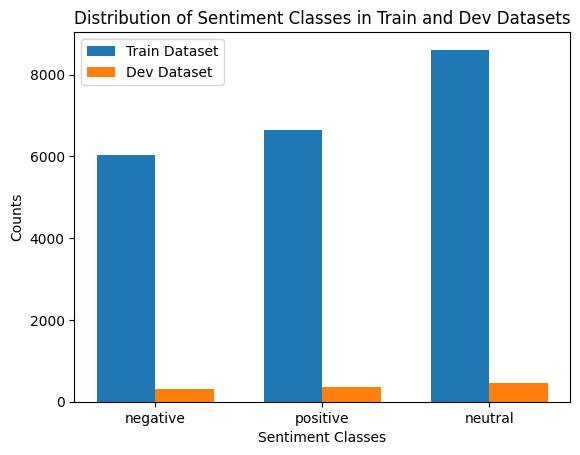

In [37]:
# YOUR CODE HERE
class_freq_outputs = class_frequency(train_df, dev_df)
categories = list(class_freq_outputs.keys())
train_counts = [counts[0] for counts in class_freq_outputs.values()]
dev_counts = [counts[1] for counts in class_freq_outputs.values()]

x = np.arange(len(categories))

fig, ax = plt.subplots()

width = 0.35
bars1 = ax.bar(x - width/2, train_counts, width, label='Train Dataset')
bars2 = ax.bar(x + width/2, dev_counts, width, label='Dev Dataset')

ax.set_xlabel('Sentiment Classes')
ax.set_ylabel('Counts')
ax.set_title('Distribution of Sentiment Classes in Train and Dev Datasets')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()




---
# 2. Sentiment Classification

## Task 2a

Train a sequence classification model. The model should take the `text` as input and return one out of 3 sentiment classes: `negative`, `neutral` or `positive`.

<img src="https://github.com/gauneg/gauneg.github.io/blob/main/sentiment_classification.png?raw=true" alt="PLOT EXAMPLE" width="500px"/>

INPUT : (`text`)

OUTPUT: `sentiment_class` i.e. one class from `(positive, negative, neutral)`


* You should have the data in the training and development sets and extract feature vectors using TF-IDF. `(10 marks)`
* The number of features in tfidf encoded data should be 1024



In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def extract_features(train_df, dev_df, test_df):
    """This function takes the dataframes for training, testing and validation and
        returns encoded features and the labels required to train the models

        X_train = [training TFIDF features]
        X_dev = [validation TFIDF features]
        X_test = [test TFIDF features]

        y_train= [lab_1, lab_2 , ..., lab_n]
        y_test= [lab_1, lab_2 , ..., lab_n]
        y_dev = [lab_1, lab_2 , ..., lab_n]
    """
    # YOUR CODE HERE
    train_df['text'] = train_df['text'].fillna('')
    dev_df['text'] = dev_df['text'].fillna('')
    test_df['text'] = test_df['text'].fillna('')

    vectorizer = TfidfVectorizer(max_features=1024)
    vectorizer.fit(train_df['text'])

    X_train = vectorizer.transform(train_df['text'])
    X_dev = vectorizer.transform(dev_df['text'])
    X_test = vectorizer.transform(test_df['text'])

    label_encoder = LabelEncoder()

    y_train = label_encoder.fit_transform(train_df['sentiment'])
    y_dev = label_encoder.transform(dev_df['sentiment'])
    y_test = label_encoder.transform(test_df['sentiment'])


    print((X_train, y_train), (X_dev, y_dev), (X_test, y_test))
    return (X_train, y_train), (X_dev, y_dev), (X_test, y_test)



    raise NotImplementedError()


In [57]:
(train_x, train_y), (dev_x, dev_y), (test_x, test_y) = extract_features(train_df, dev_df, test_df)

(<21277x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 190376 stored elements in Compressed Sparse Row format>, array([0, 2, 1, ..., 0, 1, 2])) (<1120x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 9928 stored elements in Compressed Sparse Row format>, array([1, 1, 1, ..., 2, 2, 0])) (<5084x1024 sparse matrix of type '<class 'numpy.float64'>'
	with 45327 stored elements in Compressed Sparse Row format>, array([1, 2, 2, ..., 0, 1, 1]))


In [ ]:
funct_text = inspect.getsource(extract_features)

funct_text_no_multiline_comment = re.sub(r'""".*?"""', '', funct_text, flags=re.DOTALL)

funct_no_comment = re.sub(r'^\s*#.*$', '', funct_text_no_multiline_comment, flags=re.MULTILINE)

n_fit = re.findall(r'\.fit.*\s', funct_no_comment)

assert len(n_fit) == 1


In [53]:
assert train_x.shape[0] == train_df.shape[0]
assert dev_x.shape[0] == dev_df.shape[0]
assert test_x.shape[0] == test_df.shape[0]



---
* Using these features please train a classifier using a method such Support Vector Machines (SVM) `(10 marks)`

In [58]:
from sklearn.svm import SVC

def get_model(train_x, train_y):
    # YOUR CODE HERE
    model = SVC(kernel='linear', C=1.0, random_state=42)
    model.fit(train_x, train_y)
    return model


    raise NotImplementedError()


In [59]:
model = get_model(train_x, train_y)

In [60]:
model_type = str(type(model))
assert 'sklearn' in model_type
assert 'svm' in model_type

In [61]:
def make_predictions_on_test(test_x, model):
    # YOUR CODE HERE

    predictions = model.predict(test_x)
    return predictions

    raise NotImplementedError()


In [62]:
pred_y = make_predictions_on_test(test_x, model)

In [63]:
assert len(pred_y) == test_y.shape[0]


In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calc_pre_recall_f1(pred_y, test_y):
    # YOUR CODE HERE

    precision = precision_score(test_y, pred_y, average='weighted')  # Adjust average method as needed
    recall = recall_score(test_y, pred_y, average='weighted')
    f1 = f1_score(test_y, pred_y, average='weighted')

    return precision, recall, f1
    raise NotImplementedError()


In [65]:
prec_mac_svm, rec_mac_svm, f1_mac_svm = calc_pre_recall_f1(pred_y, test_y)

In [66]:
assert prec_mac_svm <= 1.0
assert prec_mac_svm > 0.0

assert rec_mac_svm <= 1.0
assert rec_mac_svm > 0.0

assert f1_mac_svm <= 1.0
assert f1_mac_svm > 0.0

In [ ]:
# DO NOT DELETE !!!

## Task 2c

Based on the methods discussed in the lecture suggest **ONE** improvement or alternative approach that can be applied to the sentiment classification task as in Task 2a. This may be through better feature extraction, new modelling or through an alternaitve methodology.

You should implement this approach and compare the results using the evaluation from Task 2b.

Provide an **explanation** of your approach in no more than 100 words.

`(20 marks)`

## Explanation for Task

```
Put your explanation for task 2c here

```

In [ ]:
def improved_predictions(train_x, train_y, test_x):
    """
    implement an improved method for task 2a:
    1. This method should take train_x, train_y used earlier and perform learning steps.
    2. These would be the implementation of the aforementioned explanation.
    3. Then it should use the test_x to return the predictions of the classification problem
    """

    # YOUR CODE HERE
    raise NotImplementedError()


In [ ]:
y_pred_improved = improved_predictions(train_x, train_y, test_x)
assert len(y_pred_improved) == test_y.shape[0]
assert all([y in set(test_y) for y in set(y_pred_improved)])

In [ ]:
prec_mac_improv, rec_mac_improv, f1_mac_improv = calc_pre_recall_f1(y_pred_improved, test_y)
# DO NOT DELETE THIS CELL !!!

# 3. Span Extraction
## Task 3a


Our goal for this task is to extract the sentiment span, given the text and the given sentiment (true sentiment label) as input. The sentiment span is a subsection of the text that expresses the sentiment that classifies the text overall.

INPUT : (`text`, `sentiment`)

OUTPUT: `selected_text`

<img src="https://github.com/gauneg/gauneg.github.io/blob/main/assignment_diag.png?raw=true" alt="PLOT EXAMPLE" width="500px"/>

1. Describe in no more than 200 words a system that could be used to identify the sentiment span. You should consider the methodology potentially including how features are extracted, what models could be used and what procedures should be used to train the model. `(10 marks)`

## 200 words description in this cell (EDIT THIS)

---
2. Implement this system and apply it to the train and development splits of the dataset. `(15 marks)`

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

---
## Task 3b

1. Describe an automatic metric that can be used to evaluate the task of span extraction. Implement this metric and use it to evaluate the performance of the system you developed in Task 3a. `(5 marks + 10 mark)`

### Description Goes HERE

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()